In [15]:
from typing import Literal
from langgraph.graph import START, END, MessagesState, StateGraph
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage
from pydantic import BaseModel, Field
# from langchain_core.pydantic_v1 import BaseModel, Field
from tools import search_tool, web_search_tool

tools = [search_tool, web_search_tool]
model = ChatOpenAI(model="gpt-4o").bind_tools(tools)
tools_node = ToolNode(tools=tools)

class WhatsappResponse(BaseModel):
    """ Response to the user with this """
    content: str = Field(description="The content of the whatsapp message")
    language: Literal["en", "ru", "ky"] = Field(description="The language of the whatsapp message. en is for English, ru is for Russian, and ky is for Kyrgyz")

model_with_structured_output = ChatOpenAI(model="gpt-4o").with_structured_output(WhatsappResponse)

class AgentState(MessagesState):
    final_response: WhatsappResponse


def llm_node(state: AgentState):
    messages = state["messages"]
    response = model.invoke(messages)
    return { "messages": [response] }


def respond(state: AgentState):
    response = model_with_structured_output.invoke(
        [HumanMessage(content=state["messages"][-2].content)]
    )
    print(HumanMessage(content=state["messages"][-1].content))
    # We return the final answer
    return {"final_response": response}


def should_continue(state: AgentState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return "respond"


graph_builder = StateGraph(MessagesState)

graph_builder.add_node("llm", llm_node)
graph_builder.add_node("tools", tools_node)
graph_builder.add_node("respond", respond)

graph_builder.add_edge(START, "llm")
graph_builder.add_conditional_edges("llm", should_continue, {
    "tools": "tools",
    "respond": "respond"
})
graph_builder.add_edge("tools", "llm")
graph_builder.add_edge("respond", END)


memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)


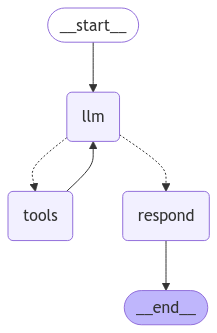

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass